In [1]:
import os
import pdb
import h5py
from collections import defaultdict

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr

# Config

In [2]:
data_dir = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/"
enformer_data_dir = "/global/scratch/users/aniketh/enformer_data/"
root_save_dir = "/global/scratch/users/aniketh/finetune-enformer/"
code_dir = "/global/home/users/aniketh/finetuning-enformer/"
fasta_path = "/clusterfs/nilah/aniketh/hg19/hg19.fa"
gene_class_path = "../finetuning/data/h5_bins_384_chrom_split/gene_class.csv"

models_dir = os.path.join(root_save_dir, "saved_models")
test_preds_dir = os.path.join(root_save_dir, "test_preds_final")
rest_unseen_preds_dir = os.path.join(root_save_dir, "rest_unseen_preds_final")
ISM_preds_dir = os.path.join(root_save_dir, "ISM")

train_h5_path = os.path.join(data_dir, "train.h5")
val_h5_path = os.path.join(data_dir, "val.h5")
test_h5_path = os.path.join(data_dir, "test.h5")
rest_unseen_h5_path = os.path.join(data_dir, "rest_unseen.h5")

GEUVADIS_COUNTS_PATH = "../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
FUSION_PREDS_DIR = "../fusion/preds"
FUSION_SCALING_PREDS_DIR = "../fusion/preds_scaling/"

all_main_run_names = {
    "classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_parallel_h5_dataset_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --data_seed {data_seed} --resume_from_checkpoint",
    "regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "single_regression_counts": "NCCL_P2P_DISABLE=1 python finetuning/train_single_counts_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    #     "single_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_single_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint", ###DOEST PERFORM WELL, NOT USED
    "joint_classification": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "joint_regression": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_enformer_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {enformer_data_dir} {run_name} {models_dir} --batch_size 1 --lr 0.0005 --weight_decay 0.005 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "joint_regression_with_Malinois_MPRA": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_with_MPRA_data_parallel_h5_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {malinois_data_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint",
    "classification_random_init": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_classification_parallel_h5_dataset_dynamic_sampling_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --data_seed {data_seed} --resume_from_checkpoint --use_random_init",
    "regression_random_init": "NCCL_P2P_DISABLE=1 python finetuning/train_pairwise_regression_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 1 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint --use_random_init",
    "single_regression_counts_random_init": "NCCL_P2P_DISABLE=1 python finetuning/train_single_counts_parallel_h5_dataset.py {train_h5_path} {val_h5_path} {run_name} {models_dir} --batch_size 2 --lr 0.0001 --weight_decay 0.001 --use_scheduler --warmup_steps 1000 --data_seed {data_seed} --resume_from_checkpoint --use_random_init",
    "baseline": "",
}
all_seeds = [42, 97, 7]
subsample_fracs = [0.2, 0.4, 0.6, 0.8]
all_afs = (
    list(np.arange(0.01, 0.1, 0.01).round(2))
    + list(np.arange(0.1, 0.4, 0.05).round(2))
    + list(np.arange(0.41, 0.49, 0.01).round(2))
)

In [3]:
ALL_PREDS_PATHS = {}
ALL_REST_UNSEEN_PREDS_PATHS = {}

# MAIN TEST RUNS
for run in all_main_run_names:
    if run == "baseline":
        ALL_PREDS_PATHS[run] = os.path.join(test_preds_dir, run)
        ALL_REST_UNSEEN_PREDS_PATHS[run] = os.path.join(rest_unseen_preds_dir, run)
    else:
        for i, seed in enumerate(all_seeds):
            train_cmd_template = all_main_run_names[run]
            lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[
                0
            ]
            wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                -1
            ].split(" ")[0]
            rcprob_used_during_training = 0.5
            rsmax_used_during_training = 3

            model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
            if "random_init" in run:
                model_name = model_name + "_random_init"

            ALL_PREDS_PATHS[model_name] = os.path.join(test_preds_dir, model_name)
            ALL_REST_UNSEEN_PREDS_PATHS[model_name] = os.path.join(
                rest_unseen_preds_dir, model_name
            )

# TEST RUNS FOR SUBSAMPLED TRAIN SET RUNS FOR REGRESSION
for run in ["regression"]:
    for i, seed in enumerate(all_seeds):
        for j, frac in enumerate(subsample_fracs):
            train_cmd_template = all_main_run_names[run]
            lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[
                0
            ]
            wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                -1
            ].split(" ")[0]
            rcprob_used_during_training = 0.5
            rsmax_used_during_training = 3

            model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}_subsample_ratio_{frac}"
            if "random_init" in run:
                model_name = model_name + "_random_init"

            ALL_PREDS_PATHS[model_name] = os.path.join(test_preds_dir, model_name)
            ALL_REST_UNSEEN_PREDS_PATHS[model_name] = os.path.join(
                rest_unseen_preds_dir, model_name
            )

# TEST RUNS USING SUBSAMPLED VARIANTS FOR REGRESSION
for run in ["regression"]:
    for i, seed in enumerate(all_seeds):
        for j, af in enumerate(all_afs):
            train_cmd_template = all_main_run_names[run]
            lr_used_during_training = train_cmd_template.split("--lr ")[-1].split(" ")[
                0
            ]
            wd_used_during_training = train_cmd_template.split("--weight_decay ")[
                -1
            ].split(" ")[0]
            rcprob_used_during_training = 0.5
            rsmax_used_during_training = 3

            model_name = f"{run}_data_seed_{seed}_lr_{lr_used_during_training}_wd_{wd_used_during_training}_rcprob_{rcprob_used_during_training}_rsmax_{rsmax_used_during_training}"
            if "random_init" in run:
                model_name = model_name + "_random_init"

            if not os.path.exists(
                os.path.join(test_preds_dir, model_name, f"af_{af}", "test_preds.npz")
            ):
                print(
                    "Dir missing", os.path.join(test_preds_dir, model_name, f"af_{af}")
                )
                continue
            ALL_PREDS_PATHS[model_name + f"_af_{af}"] = os.path.join(
                test_preds_dir, model_name, f"af_{af}"
            )

test_h5 = h5py.File(test_h5_path, "r")
rest_unseen_h5 = h5py.File(rest_unseen_h5_path, "r")

# Read test set predictions and compute correlations

In [4]:
def load_geuvadis_data() -> pd.DataFrame:
    counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col=0)
    counts_df = counts_df.reset_index().set_index("our_gene_name")
    return counts_df


def load_other_model_preds_df(preds_df_path):
    preds_df = pd.read_csv(preds_df_path, index_col=0).T
    return preds_df


def load_finetuned_preds(PREDS_PATH, h5_obj):
    """
    Returns a dictionary of dictionaries, where the outer keys are the genes
    and the inner keys are the samples. The values are the predictions.
    """
    preds_by_gene = defaultdict(dict)
    ancestries_by_gene = defaultdict(dict)
    data = np.load(os.path.join(PREDS_PATH, "test_preds.npz"))

    preds, genes, samples = data["preds"], data["genes"], data["samples"]
    ancestries = h5_obj["ancestries"]
    for (pred, gene, sample, ancestry) in zip(preds, genes, samples, ancestries):
        preds_by_gene[gene][sample] = pred
        ancestries_by_gene[gene][sample] = ancestry.decode("utf-8")
    return preds_by_gene, ancestries_by_gene


def get_finetuned_corrs(finetuned_preds, geuvadis_df):
    corrs = {}
    for g in finetuned_preds:
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())
        gene_preds = [finetuned_preds[g][s] for s in samples]
        gene_counts = geuvadis_df.loc[g, samples].values.astype("float32")
        assert np.isnan(gene_preds).sum() == 0
        assert np.isnan(gene_counts).sum() == 0
        corrs[g] = pearsonr(gene_preds, gene_counts)[0]

        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(
                f"Gene {g} has invalid predictions/counts and thus has a nan pearsonR"
            )
            corrs[g] = 0

    return corrs


def get_other_model_corrs(preds_df, geuvadis_df, finetuned_preds):
    corrs = {}
    for g in finetuned_preds:
        if g not in preds_df.columns:
            print(f"Gene {g} has no predictions/counts and thus has a nan PearsonR")
            corrs[g] = 0
            continue

        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())

        gene_preds = preds_df[g][samples].values
        gene_counts = geuvadis_df.loc[g, samples].values
        corrs[g] = pearsonr(gene_preds, gene_counts)[0]

        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(
                f"Gene {g} has invalid predictions/counts and thus has a nan PearsonR"
            )
            corrs[g] = 0

    return corrs


def summarize_perf(corrs):
    genes = list(corrs.keys())
    corrs_l = [corrs[g] for g in genes]

    df = pd.DataFrame(
        {
            "gene": genes,
            "Pearson": corrs_l,
            "|Pearson|": np.abs(corrs_l),
        }
    )

    return df

In [5]:
gene_class = pd.read_csv(gene_class_path)
geuvadis_df = load_geuvadis_data()
geuvadis_df["gene"] = geuvadis_df.index
gene_class = gene_class.merge(
    geuvadis_df[["gene", "Chr"]], on="gene", how="right"
).reset_index(drop=True)
gene_class.loc[pd.isna(gene_class["class"]), "class"] = "unseen"

fusion_dfs = {}
for model_csv in os.listdir(FUSION_PREDS_DIR):
    if model_csv.endswith(".csv"):
        fusion_dfs[model_csv.split(".")[0]] = load_other_model_preds_df(
            os.path.join(FUSION_PREDS_DIR, model_csv)
        )

In [6]:
if (
    (not os.path.exists("all_gene_perf.csv"))
    or (not os.path.exists("perf_summary.csv"))
    or (not os.path.exists("fusion_scaling.csv"))
):
    if not os.path.exists("all_gene_perf.csv"):
        gene_perf = None
        finetuned_preds_for_baseline_comparison, _ = load_finetuned_preds(
            ALL_PREDS_PATHS[
                "regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3"
            ],
            test_h5,
        )

        for model in ALL_PREDS_PATHS:
            print(model)

            PREDS_PATH = ALL_PREDS_PATHS[model]
            finetuned_preds, ancestries_by_gene = load_finetuned_preds(
                PREDS_PATH, test_h5
            )
            finetuned_corrs = get_finetuned_corrs(finetuned_preds, geuvadis_df)

            if not ("_af_" in model):
                REST_UNSEEN_PREDS_PATH = ALL_REST_UNSEEN_PREDS_PATHS[model]
                (
                    rest_unseen_finetuned_preds,
                    rest_unseen_ancestries_by_gene,
                ) = load_finetuned_preds(REST_UNSEEN_PREDS_PATH, rest_unseen_h5)
                rest_unseen_finetuned_corrs = get_finetuned_corrs(
                    rest_unseen_finetuned_preds, geuvadis_df
                )

                finetuned_corrs.update(rest_unseen_finetuned_corrs)
                finetuned_preds.update(rest_unseen_finetuned_preds)
                ancestries_by_gene.update(rest_unseen_ancestries_by_gene)

            corrs_df = summarize_perf(finetuned_corrs)
            corrs_df["model"] = model
            if gene_perf is None:
                gene_perf = corrs_df.copy()
            else:
                gene_perf = pd.concat([gene_perf, corrs_df]).reset_index(drop=True)

        model_names = {
            "top1": "Top SNP",
            "blup": "BLUP",
            "enet": "Elastic Net/\nPrediXcan",
            "lasso": "LASSO",
            "bslmm": "BSLMM",
        }
        for model in fusion_dfs:
            model_corrs = get_other_model_corrs(
                fusion_dfs[model], geuvadis_df, finetuned_preds_for_baseline_comparison
            )

            corrs_df = summarize_perf(model_corrs)
            corrs_df["model"] = model_names[model]

            gene_perf = pd.concat([gene_perf, corrs_df]).reset_index(drop=True)

        gene_perf = gene_perf.merge(gene_class, on="gene", how="inner").reset_index(
            drop=True
        )
        gene_perf.to_csv("all_gene_perf.csv", index=False)
    else:
        gene_perf = pd.read_csv("all_gene_perf.csv")

    seen_chrs = set(gene_perf[gene_perf["class"] != "unseen"]["Chr"])

    for split in ["random_split", "yri_split", "unseen"]:
        print(
            f"Num genes in {split} before filtering out unseen genes on train chromosomes = {len(set(gene_perf[gene_perf['class'] == split]['gene']))}"
        )

    gene_perf["is_not_on_a_train_chr"] = gene_perf.apply(
        lambda x: x["Chr"] not in seen_chrs, axis=1
    )
    gene_perf = gene_perf[
        (gene_perf["is_not_on_a_train_chr"] & (gene_perf["class"] == "unseen"))
        | (gene_perf["class"] != "unseen")
    ].reset_index(drop=True)
    for split in ["random_split", "yri_split", "unseen"]:
        print(
            f"Num genes in {split} after filtering out unseen genes on train chromosomes = {len(set(gene_perf[gene_perf['class'] == split]['gene']))}"
        )

    summary_df = {}
    summary_df["Model"] = []
    summary_df["n_random_split"] = []
    summary_df["n_yri_split"] = []
    summary_df["n_unseen"] = []
    summary_df["random_split Genes Avg PearsonR"] = []
    summary_df["yri_split Genes Avg PearsonR"] = []
    summary_df["unseen Genes Avg PearsonR"] = []
    summary_df["random_split Genes Avg |PearsonR|"] = []
    summary_df["yri_split Genes Avg |PearsonR|"] = []
    summary_df["unseen Genes Avg |PearsonR|"] = []

    for model, model_df in gene_perf.groupby("model"):
        summary_df["Model"].append(model)
        for split in ["random_split", "yri_split", "unseen"]:
            split_df = model_df[model_df["class"] == split]

            mean_pearson = split_df["Pearson"].mean()
            mean_abs_pearson = split_df["|Pearson|"].mean()

            summary_df[f"n_{split}"].append(split_df.shape[0])
            summary_df[f"{split} Genes Avg PearsonR"].append(mean_pearson)
            summary_df[f"{split} Genes Avg |PearsonR|"].append(mean_abs_pearson)

    summary_df = pd.DataFrame(summary_df)

    model_type = []
    replicate = []
    subsample_ratio = []
    min_af = []

    for i in range(summary_df.shape[0]):
        row = summary_df.iloc[i]

        if row["Model"].startswith("baseline"):
            model_type.append("Baseline Enformer")
            replicate.append(0)
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("classification_"):
            model_type.append("Pairwise \nClassification")
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("regression_"):
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            if "subsample" in row["Model"]:
                subsample_ratio.append(
                    float(row["Model"].split("subsample_ratio_")[-1])
                )
                min_af.append(-1)
                model_type.append(
                    "Pairwise \nRegression \nwith {}% of Samples".format(
                        int(subsample_ratio[-1] * 100)
                    )
                )
            else:
                subsample_ratio.append(1.0)
                if "_af_" in row["Model"]:
                    min_af.append(float(row["Model"].split("_af_")[-1]))
                    model_type.append("Pairwise \nRegression")
                else:
                    min_af.append(0.0)
                    model_type.append("Pairwise \nRegression")

        elif row["Model"].startswith("single_regression_"):
            model_type.append("Single Sample \nRegression")
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("joint_classification_"):
            model_type.append(
                "Pairwise \nClassification \nwith Original Data \nJoint Training"
            )
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("joint_regression_with_Malinois_MPRA_"):
            model_type.append("Pairwise \nRegression \nwith MPRA Data \nJoint Training")
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        elif row["Model"].startswith("joint_regression_"):
            model_type.append(
                "Pairwise \nRegression \nwith Original Data \nJoint Training"
            )
            replicate.append(int(row["Model"].split("data_seed_")[-1].split("_")[0]))
            subsample_ratio.append(-1)
            min_af.append(-1)

        else:
            model_type.append(row["Model"])
            replicate.append(0)
            subsample_ratio.append(-1)
            min_af.append(-1)

        if "random_init" in row["Model"]:
            model_type[-1] = model_type[-1] + "\nwith randomly \ninitialized model"

    summary_df["Model Type"] = model_type
    summary_df["Replicate"] = replicate
    summary_df["Subsample Ratio"] = subsample_ratio
    summary_df["Min AF"] = min_af

    summary_df.to_csv("perf_summary.csv", index=False)

    fusion_scaling_df = {}
    fusion_scaling_df["Model"] = []
    fusion_scaling_df["random_split Genes Avg PearsonR"] = []
    fusion_scaling_df["yri_split Genes Avg PearsonR"] = []
    fusion_scaling_df["unseen Genes Avg PearsonR"] = []
    fusion_scaling_df["random_split Genes Avg |PearsonR|"] = []
    fusion_scaling_df["yri_split Genes Avg |PearsonR|"] = []
    fusion_scaling_df["unseen Genes Avg |PearsonR|"] = []
    fusion_scaling_df["Replicate"] = []
    fusion_scaling_df["Subsample Ratio"] = []

    for subset_dir in os.listdir(FUSION_SCALING_PREDS_DIR):
        if subset_dir.startswith("subset_"):
            subsample_ratio = int(subset_dir.split("_")[-1])
            for replicate_dir in os.listdir(
                os.path.join(FUSION_SCALING_PREDS_DIR, subset_dir)
            ):
                if replicate_dir.startswith("replicate_"):
                    replicate_num = replicate_dir.split("_")[-1]
                    csv_path = os.path.join(
                        FUSION_SCALING_PREDS_DIR, subset_dir, replicate_dir, "blup.csv"
                    )
                    preds = load_other_model_preds_df(csv_path)

                    model_corrs = get_other_model_corrs(
                        preds, geuvadis_df, finetuned_preds_for_baseline_comparison
                    )
                    corrs_df = summarize_perf(model_corrs)

                    corrs_df = corrs_df.merge(gene_class, on="gene", how="inner")

                    for split in ["random_split", "yri_split", "unseen"]:
                        split_df = corrs_df[corrs_df["class"] == split]
                        mean_pearson = split_df["Pearson"].mean()
                        mean_abs_pearson = split_df["|Pearson|"].mean()
                        fusion_scaling_df[f"{split} Genes Avg PearsonR"].append(
                            mean_pearson
                        )
                        fusion_scaling_df[f"{split} Genes Avg |PearsonR|"].append(
                            mean_abs_pearson
                        )

                    fusion_scaling_df["Model"].append("BLUP")
                    fusion_scaling_df["Replicate"].append(replicate_num)
                    fusion_scaling_df["Subsample Ratio"].append(subsample_ratio)

    fusion_scaling_df = pd.DataFrame(fusion_scaling_df)
    fusion_scaling_df.to_csv("fusion_scaling.csv", index=False)
else:
    gene_perf = pd.read_csv("all_gene_perf.csv")
    summary_df = pd.read_csv("perf_summary.csv")
    fusion_scaling_df = pd.read_csv("fusion_scaling.csv")

classification_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
classification_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
classification_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
single_regression_counts_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
single_regression_counts_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
single_regression_counts_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
joint_classification_data_seed_42_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
joint_classification_data_seed_97_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
joint_classification_data_seed_7_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
joint_regression_data_seed_42_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
joint_regression_data_seed_97_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
joint_regression_data_seed_7_lr_0.0005_wd_0.005_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
joint_regression_with_Malinois_MPRA_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
joint_regression_with_Malinois_MPRA_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
joint_regression_with_Malinois_MPRA_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
classification_random_init_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_random_init


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
classification_random_init_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_random_init


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
classification_random_init_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_random_init


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_random_init_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_random_init


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_random_init_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_random_init


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_random_init_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_random_init


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
single_regression_counts_random_init_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_random_init


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
single_regression_counts_random_init_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_random_init


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
single_regression_counts_random_init_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_random_init


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
baseline


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.2


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.4


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.6


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.8


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.2


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.4


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.6


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.8


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.2


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.4


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.6


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_subsample_ratio_0.8


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ensg00000184779 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000196648 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000197701 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene nprl3 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr3k has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene snrnp25 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene znf718 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.01


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.02


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.03


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.04


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.05


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.06


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.07


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.08


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.09


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.1


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.15


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.2


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.25


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.35


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.4


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene tmem163 has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.41


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem163 has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.42


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR
Gene borcs7 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000232116 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem163 has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.43


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR
Gene borcs7 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000232116 has invalid predictions/counts and thus has a nan 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene adk has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene tctn2 has invalid predictions/counts and thus has a nan pearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem1

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene brk1 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.44


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene cdc42bpa has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR
Gene borcs7 has invalid predictions/counts and thus has a nan pearson

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene znf354a has invalid predictions/counts and thus has a nan pearsonR
Gene ftcdnl1 has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene adk has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene e

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene brk1 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR
Gene hyal4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.45


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene mtmr4 has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene foxred1 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene ra

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene al354740.1 has invalid predictions/counts and thus has a nan pearsonR
Gene kptn has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
G

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene znf354a has invalid predictions/counts and thus has a nan pearsonR
Gene ftcdnl1 has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearson

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene mttp has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene brk1 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR
Gene arhgef35 has invalid predictions/counts and thus has a nan pearsonR
Ge

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.46


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene ap4b1 has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene mtmr4 has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap35 has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene ighmbp2 has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene foxred1 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo h

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene al354740.1 has invalid predictions/counts and thus has a nan pearsonR
Gene kptn has invalid predictions/counts and thus has a nan pearsonR
Gene glul has invalid predictions/counts and thus has a nan pearsonR
Ge

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01006 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene tnc has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4m1 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene znf354a has invalid predictions/counts and thus has a nan pearso

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene mttp has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene itgb1 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bbs12 has invalid predictions/counts and thus has a nan pearsonR
Gene nelfb has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene rnf

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.47


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene colca2 has invalid predictions/counts and thus has a nan pearsonR
Gene sdccag8 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4b1 has invalid predictions/counts and thus has a nan pearsonR
Gene rnf43 has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene mtmr4 has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap35 has invalid predictions/counts and thus has a nan pearsonR
Gene sdhaf4 has invalid predictions/counts and thus has a nan pearsonR
Gene smtnl1 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene cenpq has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene ppan has invalid predictions/counts and thus has a nan pearsonR
Gene al354740.1 has invalid predictions/counts and thus has a nan pearsonR
G

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene atp7b has invalid predictions/counts and thus has a nan pearsonR
Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01006 has invalid predictions/counts and thus has a nan pearsonR
Gene cox17 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene tmtc4 has invalid predictions/counts and thus has a nan pearsonR
Gene tnc has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene mttp has invalid predictions/counts and thus has a nan pearsonR
Gene nlrc4 has invalid predictions/counts and thus has a nan pearsonR
Gene hmhb1 has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene itgb1 has invalid predictions/counts and thus has a nan pearsonR
Gene slc18a2 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene ptbp3 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa12

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.48


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene svbp has invalid predictions/counts and thus has a nan pearsonR
Gene exosc5 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene cd58 has invalid predictions/counts and thus has a nan pearsonR
Gene yif1a has invalid predictions/counts and thus has a nan pearsonR
Gene mag has invalid predictions/counts and thus has a nan pearsonR
Gene colca2 has invalid predictions/counts and thus has a nan pearsonR
Gene sdccag8 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4b1 has invalid predictions/counts and thus has a nan pearsonR
Gene rnf43 has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has inva

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene mthfr has invalid predictions/counts and thus has a nan pearsonR
Gene dmac2 has invalid predictions/counts and thus has a nan pearsonR
Gene cenpq has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene cox17 has invalid predictions/counts and thus has a nan pearsonR
Gene thumpd3 has invalid predictions/counts and thus has a nan pearsonR
Gene hat1 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene tmtc4 has invalid predictions/counts and thus has a nan pearsonR
Gene tnc has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4m1 has invalid predictions/counts and thus has a nan pearsonR
Gene ei

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene itgb1 has invalid predictions/counts and thus has a nan pearsonR
Gene slc18a2 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpc has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene ptbp3 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bbs12 has invalid predictions/counts and thus has a nan pearsonR
Gene nelfb has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.49


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene calm3 has invalid predictions/counts and thus has a nan pearsonR
Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene acat1 has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene svbp has invalid predictions/counts and thus has a nan pearsonR
Gene al160408.3 has invalid predictions/counts and thus has a nan pearsonR
Gene exosc5 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene faap24 has invalid predictions/counts and thus has a nan pearsonR
Gene cd58 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000006075 has invalid predictions/counts and thus has a nan pearsonR
Gene yif1a has invalid predictions/counts and thus has a nan pearsonR
Gene mag has invalid predictions/counts and thus has a nan pearsonR
Gene c

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01531 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene mthfr has invalid predictions/counts and thus has a nan pearsonR
Gene taf1a has invalid predictions/counts and thus has a nan pearsonR
Gene dmac2 has invalid predictions/counts and thus has a nan pearsonR
Gene cenpq has invalid predictions/counts and thus has a nan pearsonR
Gene chaf1a has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ens

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene hat1 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene adamts6 has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene slc16a9 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene hdhd3 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene mgmt has invalid predictions/counts and thus has a nan pearsonR
Gene ac104653.1 has invalid predictions/counts and thus has a nan pearsonR
Gene tmtc4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene synpo2 has invalid predictions/counts and thus has a nan pearsonR
Gene xpc has invalid predictions/counts and thus has a nan pearsonR
Gene cfap91 has invalid predictions/counts and thus has a nan pearsonR
Gene b3gnt7 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc27 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene acox3 has invalid predictions/counts and thus has a nan pearsonR
Gene anxa6 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene ptbp3 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene fam23

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.01


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.02


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.03


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.04


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.05


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.06


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.07


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.08


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.09


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.1


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.15


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.2


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.25


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.35


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.4


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene tmem163 has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.41


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem163 has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.42


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR
Gene borcs7 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000232116 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem163 has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.43


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR
Gene borcs7 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000232116 has invalid predictions/counts and thus has a nan 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene adk has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene tctn2 has invalid predictions/counts and thus has a nan pearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem1

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene brk1 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.44


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene cdc42bpa has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR
Gene borcs7 has invalid predictions/counts and thus has a nan pearson

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene znf354a has invalid predictions/counts and thus has a nan pearsonR
Gene ftcdnl1 has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene adk has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene e

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene brk1 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR
Gene hyal4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.45


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene mtmr4 has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene foxred1 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene ra

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene al354740.1 has invalid predictions/counts and thus has a nan pearsonR
Gene kptn has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
G

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene znf354a has invalid predictions/counts and thus has a nan pearsonR
Gene ftcdnl1 has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearson

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene mttp has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene brk1 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR
Gene arhgef35 has invalid predictions/counts and thus has a nan pearsonR
Ge

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.46


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene ap4b1 has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene mtmr4 has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap35 has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene ighmbp2 has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene foxred1 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo h

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene al354740.1 has invalid predictions/counts and thus has a nan pearsonR
Gene kptn has invalid predictions/counts and thus has a nan pearsonR
Gene glul has invalid predictions/counts and thus has a nan pearsonR
Ge

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01006 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene tnc has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4m1 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene znf354a has invalid predictions/counts and thus has a nan pearso

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene mttp has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene itgb1 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bbs12 has invalid predictions/counts and thus has a nan pearsonR
Gene nelfb has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene rnf

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.47


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene colca2 has invalid predictions/counts and thus has a nan pearsonR
Gene sdccag8 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4b1 has invalid predictions/counts and thus has a nan pearsonR
Gene rnf43 has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene mtmr4 has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap35 has invalid predictions/counts and thus has a nan pearsonR
Gene sdhaf4 has invalid predictions/counts and thus has a nan pearsonR
Gene smtnl1 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene cenpq has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene ppan has invalid predictions/counts and thus has a nan pearsonR
Gene al354740.1 has invalid predictions/counts and thus has a nan pearsonR
G

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene atp7b has invalid predictions/counts and thus has a nan pearsonR
Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01006 has invalid predictions/counts and thus has a nan pearsonR
Gene cox17 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene tmtc4 has invalid predictions/counts and thus has a nan pearsonR
Gene tnc has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene mttp has invalid predictions/counts and thus has a nan pearsonR
Gene nlrc4 has invalid predictions/counts and thus has a nan pearsonR
Gene hmhb1 has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene itgb1 has invalid predictions/counts and thus has a nan pearsonR
Gene slc18a2 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene ptbp3 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa12

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.48


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene svbp has invalid predictions/counts and thus has a nan pearsonR
Gene exosc5 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene cd58 has invalid predictions/counts and thus has a nan pearsonR
Gene yif1a has invalid predictions/counts and thus has a nan pearsonR
Gene mag has invalid predictions/counts and thus has a nan pearsonR
Gene colca2 has invalid predictions/counts and thus has a nan pearsonR
Gene sdccag8 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4b1 has invalid predictions/counts and thus has a nan pearsonR
Gene rnf43 has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has inva

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene mthfr has invalid predictions/counts and thus has a nan pearsonR
Gene dmac2 has invalid predictions/counts and thus has a nan pearsonR
Gene cenpq has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene linc01006 has invalid predictions/counts and thus has a nan pearsonR
Gene cox17 has invalid predictions/counts and thus has a nan pearsonR
Gene thumpd3 has invalid predictions/counts and thus has a nan pearsonR
Gene hat1 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene tmtc4 has invalid predictions/counts and thus has a nan pearsonR
Gene tnc has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gen

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene itgb1 has invalid predictions/counts and thus has a nan pearsonR
Gene slc18a2 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpc has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene ptbp3 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bbs12 has invalid predictions/counts and thus has a nan pearsonR
Gene nelfb has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.49


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene calm3 has invalid predictions/counts and thus has a nan pearsonR
Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene acat1 has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene svbp has invalid predictions/counts and thus has a nan pearsonR
Gene al160408.3 has invalid predictions/counts and thus has a nan pearsonR
Gene exosc5 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene faap24 has invalid predictions/counts and thus has a nan pearsonR
Gene cd58 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000006075 has invalid predictions/counts and thus has a nan pearsonR
Gene yif1a has invalid predictions/counts and thus has a nan pearsonR
Gene mag has invalid predictions/counts and thus has a nan pearsonR
Gene c

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01531 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene mthfr has invalid predictions/counts and thus has a nan pearsonR
Gene taf1a has invalid predictions/counts and thus has a nan pearsonR
Gene dmac2 has invalid predictions/counts and thus has a nan pearsonR
Gene cenpq has invalid predictions/counts and thus has a nan pearsonR
Gene chaf1a has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ens

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene hat1 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene adamts6 has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene slc16a9 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene hdhd3 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene mgmt has invalid predictions/counts and thus has a nan pearsonR
Gene ac104653.1 has invalid predictions/counts and thus has a nan pearsonR
Gene tmtc4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene synpo2 has invalid predictions/counts and thus has a nan pearsonR
Gene xpc has invalid predictions/counts and thus has a nan pearsonR
Gene cfap91 has invalid predictions/counts and thus has a nan pearsonR
Gene b3gnt7 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc27 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene acox3 has invalid predictions/counts and thus has a nan pearsonR
Gene anxa6 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene ptbp3 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene fam23

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.01


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.02


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.03


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.04


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.05


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.06


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.07


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.08


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.09


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.1


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.15


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.2


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.25


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.3


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.35


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.4


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene tmem163 has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.41


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem163 has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.42


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR
Gene borcs7 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000232116 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem163 has invalid predictions/counts and thus has a nan pearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan pearsonR
Gene 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.43


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR
Gene borcs7 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000232116 has invalid predictions/counts and thus has a nan 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene adk has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene eif4b has invalid predictions/counts and thus has a nan pearsonR
Gene tctn2 has invalid predictions/counts and thus has a nan pearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem1

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene brk1 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.44


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene rabac1 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc37a3 has invalid predictions/counts and thus has a nan pearsonR
Gene cdc42bpa has invalid predictions/counts and thus has a nan pearsonR
Gene prdx5 has invalid predictions/counts and thus has a nan pearsonR
Gene borcs7 has invalid predictions/counts and thus has a nan pearson

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene znf354a has invalid predictions/counts and thus has a nan pearsonR
Gene ftcdnl1 has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearsonR
Gene adk has invalid predictions/counts and thus has a nan pearsonR
Gene c4orf33 has invalid predictions/counts and thus has a nan pearsonR
Gene aftph has invalid predictions/counts and thus has a nan pearsonR
Gene ppip5k2 has invalid predictions/counts and thus has a nan pearsonR
Gene e

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene brk1 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR
Gene hyal4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.45


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene mtmr4 has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene foxred1 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000174100 has invalid predictions/counts and thus has a nan pearsonR
Gene hebp2 has invalid predictions/counts and thus has a nan pearsonR
Gene ra

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene al354740.1 has invalid predictions/counts and thus has a nan pearsonR
Gene kptn has invalid predictions/counts and thus has a nan pearsonR
Gene rhot1 has invalid predictions/counts and thus has a nan pearsonR
G

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene znf354a has invalid predictions/counts and thus has a nan pearsonR
Gene ftcdnl1 has invalid predictions/counts and thus has a nan pearsonR
Gene fgf2 has invalid predictions/counts and thus has a nan pearsonR
Gene kalrn has invalid predictions/counts and thus has a nan pearson

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene mttp has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene brk1 has invalid predictions/counts and thus has a nan pearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan pearsonR
Gene dmgdh has invalid predictions/counts and thus has a nan pearsonR
Gene arhgef35 has invalid predictions/counts and thus has a nan pearsonR
Ge

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.46


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene ap4b1 has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene mtmr4 has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap35 has invalid predictions/counts and thus has a nan pearsonR
Gene pdhx has invalid predictions/counts and thus has a nan pearsonR
Gene ighmbp2 has invalid predictions/counts and thus has a nan pearsonR
Gene c1orf216 has invalid predictions/counts and thus has a nan pearsonR
Gene foxred1 has invalid predictions/counts and thus has a nan pearsonR
Gene dxo h

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene al354740.1 has invalid predictions/counts and thus has a nan pearsonR
Gene kptn has invalid predictions/counts and thus has a nan pearsonR
Gene glul has invalid predictions/counts and thus has a nan pearsonR
Ge

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01006 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene tnc has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4m1 has invalid predictions/counts and thus has a nan pearsonR
Gene eif2ak3-dt has invalid predictions/counts and thus has a nan pearsonR
Gene znf354a has invalid predictions/counts and thus has a nan pearso

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene mttp has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene itgb1 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bbs12 has invalid predictions/counts and thus has a nan pearsonR
Gene nelfb has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2h2c has invalid predictions/counts and thus has a nan pearsonR
Gene rnf

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.47


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene colca2 has invalid predictions/counts and thus has a nan pearsonR
Gene sdccag8 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4b1 has invalid predictions/counts and thus has a nan pearsonR
Gene rnf43 has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has invalid predictions/counts and thus has a nan pearsonR
Gene mtmr4 has invalid predictions/counts and thus has a nan pearsonR
Gene eif3i has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap35 has invalid predictions/counts and thus has a nan pearsonR
Gene sdhaf4 has invalid predictions/counts and thus has a nan pearsonR
Gene smtnl1 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene cenpq has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene ppan has invalid predictions/counts and thus has a nan pearsonR
Gene al354740.1 has invalid predictions/counts and thus has a nan pearsonR
G

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene atp7b has invalid predictions/counts and thus has a nan pearsonR
Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01006 has invalid predictions/counts and thus has a nan pearsonR
Gene cox17 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene tmtc4 has invalid predictions/counts and thus has a nan pearsonR
Gene tnc has invalid predictions/counts and thus has a nan pearsonR
Gene spryd3 has invalid predictions/counts and thus has a nan pearsonR
Gene

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene nlrc4 has invalid predictions/counts and thus has a nan pearsonR
Gene hmhb1 has invalid predictions/counts and thus has a nan pearsonR
Gene p2ry1 has invalid predictions/counts and thus has a nan pearsonR
Gene itgb1 has invalid predictions/counts and thus has a nan pearsonR
Gene slc18a2 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene ptbp3 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bb

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.48


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene svbp has invalid predictions/counts and thus has a nan pearsonR
Gene exosc5 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene cd58 has invalid predictions/counts and thus has a nan pearsonR
Gene yif1a has invalid predictions/counts and thus has a nan pearsonR
Gene mag has invalid predictions/counts and thus has a nan pearsonR
Gene colca2 has invalid predictions/counts and thus has a nan pearsonR
Gene sdccag8 has invalid predictions/counts and thus has a nan pearsonR
Gene ap4b1 has invalid predictions/counts and thus has a nan pearsonR
Gene rnf43 has invalid predictions/counts and thus has a nan pearsonR
Gene llgl1 has invalid predictions/counts and thus has a nan pearsonR
Gene coprs has inva

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene etv2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene mthfr has invalid predictions/counts and thus has a nan pearsonR
Gene dmac2 has invalid predictions/counts and thus has a nan pearsonR
Gene cenpq has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000241768 has invalid predictions/counts and thus has a nan pearsonR
Gene fdxr has invalid predictions/counts and thus has a nan pearsonR
Gene 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rps14 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01006 has invalid predictions/counts and thus has a nan pearsonR
Gene cox17 has invalid predictions/counts and thus has a nan pearsonR
Gene thumpd3 has invalid predictions/counts and thus has a nan pearsonR
Gene hat1 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene tmtc4 has invalid predictions/counts and thus has a nan pearsonR
Gene tnc has invalid predictions/counts and thus has a nan pearsonR
Gene

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene itgb1 has invalid predictions/counts and thus has a nan pearsonR
Gene slc18a2 has invalid predictions/counts and thus has a nan pearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene xpc has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene ptbp3 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene matr3 has invalid predictions/counts and thus has a nan pearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan pearsonR
Gene bbs12 has invalid predictions/counts and thus has a nan pearsonR
Gene nelfb has invalid predictions/counts and thus has a nan pearsonR
Gene gtf2

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR
regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3_af_0.49


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene calm3 has invalid predictions/counts and thus has a nan pearsonR
Gene rwdd2b has invalid predictions/counts and thus has a nan pearsonR
Gene acat1 has invalid predictions/counts and thus has a nan pearsonR
Gene sytl2 has invalid predictions/counts and thus has a nan pearsonR
Gene znf615 has invalid predictions/counts and thus has a nan pearsonR
Gene svbp has invalid predictions/counts and thus has a nan pearsonR
Gene al160408.3 has invalid predictions/counts and thus has a nan pearsonR
Gene exosc5 has invalid predictions/counts and thus has a nan pearsonR
Gene tpbg has invalid predictions/counts and thus has a nan pearsonR
Gene faap24 has invalid predictions/counts and thus has a nan pearsonR
Gene cd58 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000006075 has invalid predictions/counts and thus has a nan pearsonR
Gene yif1a has invalid predictions/counts and thus has a nan pearsonR
Gene mag has invalid predictions/counts and thus has a nan pearsonR
Gene c

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene znf283 has invalid predictions/counts and thus has a nan pearsonR
Gene linc01531 has invalid predictions/counts and thus has a nan pearsonR
Gene tmem30a has invalid predictions/counts and thus has a nan pearsonR
Gene neat1 has invalid predictions/counts and thus has a nan pearsonR
Gene mtarc2 has invalid predictions/counts and thus has a nan pearsonR
Gene rapgefl1 has invalid predictions/counts and thus has a nan pearsonR
Gene mthfr has invalid predictions/counts and thus has a nan pearsonR
Gene taf1a has invalid predictions/counts and thus has a nan pearsonR
Gene dmac2 has invalid predictions/counts and thus has a nan pearsonR
Gene cenpq has invalid predictions/counts and thus has a nan pearsonR
Gene chaf1a has invalid predictions/counts and thus has a nan pearsonR
Gene sort1 has invalid predictions/counts and thus has a nan pearsonR
Gene dram2 has invalid predictions/counts and thus has a nan pearsonR
Gene cep85 has invalid predictions/counts and thus has a nan pearsonR
Gene ens

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene hat1 has invalid predictions/counts and thus has a nan pearsonR
Gene rab33b has invalid predictions/counts and thus has a nan pearsonR
Gene adamts6 has invalid predictions/counts and thus has a nan pearsonR
Gene nup35 has invalid predictions/counts and thus has a nan pearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan pearsonR
Gene mxi1 has invalid predictions/counts and thus has a nan pearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan pearsonR
Gene slc16a9 has invalid predictions/counts and thus has a nan pearsonR
Gene gype has invalid predictions/counts and thus has a nan pearsonR
Gene hdhd3 has invalid predictions/counts and thus has a nan pearsonR
Gene rasa4b has invalid predictions/counts and thus has a nan pearsonR
Gene mgmt has invalid predictions/counts and thus has a nan pearsonR
Gene ac104653.1 has invalid predictions/counts and thus has a nan pearsonR
Gene tmtc4 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene rfx3-as1 has invalid predictions/counts and thus has a nan pearsonR
Gene plekha5 has invalid predictions/counts and thus has a nan pearsonR
Gene synpo2 has invalid predictions/counts and thus has a nan pearsonR
Gene xpc has invalid predictions/counts and thus has a nan pearsonR
Gene cfap91 has invalid predictions/counts and thus has a nan pearsonR
Gene b3gnt7 has invalid predictions/counts and thus has a nan pearsonR
Gene lrrc27 has invalid predictions/counts and thus has a nan pearsonR
Gene sestd1 has invalid predictions/counts and thus has a nan pearsonR
Gene xpnpep1 has invalid predictions/counts and thus has a nan pearsonR
Gene acox3 has invalid predictions/counts and thus has a nan pearsonR
Gene anxa6 has invalid predictions/counts and thus has a nan pearsonR
Gene higd2a has invalid predictions/counts and thus has a nan pearsonR
Gene ptbp3 has invalid predictions/counts and thus has a nan pearsonR
Gene hadh has invalid predictions/counts and thus has a nan pearsonR
Gene fam23

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene golga6l9 has invalid predictions/counts and thus has a nan pearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene linc02397 has invalid predictions/counts and thus has a nan PearsonR
Gene magohb has invalid predictions/counts and thus has a nan PearsonR
Gene tctn2 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene prxl2c has invalid predictions/counts and thus has a nan PearsonR
Gene csta has invalid predictions/counts and thus has a nan PearsonR
Gene plxdc2 has invalid predictions/counts and thus has a nan PearsonR
Gene hadh has invalid predictions/counts and thus has a nan PearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan PearsonR
Gene tlr1 has invalid predictions/counts and thus has a nan PearsonR
Gene slc31a1 has invalid predictions/counts and thus has a nan PearsonR
Gene prune2 has invalid predictions/counts and thus has a nan PearsonR
Gene sec24b-as1 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no p

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene dxo has invalid predictions/counts and thus has a nan PearsonR
Gene dmac2 has invalid predictions/counts and thus has a nan PearsonR
Gene dus1l has invalid predictions/counts and thus has a nan PearsonR
Gene dnah17 has invalid predictions/counts and thus has a nan PearsonR
Gene itgae has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene ensg00000145965 has invalid predictions/counts and thus has a nan PearsonR
Gene slc39a1 has invalid predictions/counts and thus has a nan PearsonR
Gene lilrb2 has invalid predictions/counts and thus has a nan PearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan PearsonR
Gene pigo has invalid predictions/counts and thus has a nan PearsonR
Gene ensg00000204807 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene kalrn has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene ap3b1 has invalid predictions/counts and thus has a nan PearsonR
Gene prxl2c has invalid predictions/counts and thus has a nan PearsonR
Gene cep41 has invalid predictions/counts and thus has a nan PearsonR
Gene plxdc2 has invalid predictions/counts and thus has a nan PearsonR
Gene rfx3-as1 has invalid predictions/counts and thus has a nan PearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan PearsonR
Gene tnik has invalid predictions/counts and thus has a nan PearsonR
Gene ptpre has invalid predictions/counts and thus has a nan PearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene sec24b-as1 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan PearsonR
Gene c15orf39 has no predictions/counts and thus has a nan 

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene dmac2 has invalid predictions/counts and thus has a nan PearsonR
Gene dnah17 has invalid predictions/counts and thus has a nan PearsonR
Gene lilrb2 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene tcaf1 has invalid predictions/counts and thus has a nan PearsonR
Gene hat1 has invalid predictions/counts and thus has a nan PearsonR
Gene arhgap24 has invalid predictions/counts and thus has a nan PearsonR
Gene pigo has invalid predictions/counts and thus has a nan PearsonR
Gene kalrn has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene prxl2c has invalid predictions/counts and thus has a nan PearsonR
Gene cep41 has invalid predictions/counts and thus has a nan PearsonR
Gene plxdc2 has invalid predictions/counts and thus has a nan PearsonR
Gene kiaa1217 has invalid predictions/counts and thus has a nan PearsonR
Gene tlr1 has invalid predictions/counts and thus has a nan PearsonR
Gene tnik has invalid predictions/counts and thus has a nan PearsonR
Gene ptpre has invalid predictions/counts and thus has a nan PearsonR
Gene bx088651.4 has invalid predictions/counts and thus has a nan PearsonR
Gene sec24b-as1 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has n

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene sycp2l has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan PearsonR
Gene c15orf39 has no predictions/counts and thus has a nan Pear

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene plxna2 has invalid predictions/counts and thus has a nan PearsonR
Gene lilrb2 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan P

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene hat1 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan PearsonR
Gene c15orf39 has no predictions/counts and thus has a nan Pearso

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene kalrn has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan PearsonR
Gene c15orf39 has no predictions/counts and thus has a nan Pears

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene itgb1 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan PearsonR
Gene c15orf39 has no predictions/counts and thus has a nan Pears

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene pdss2 has invalid predictions/counts and thus has a nan PearsonR
Gene arhgap18 has invalid predictions/counts and thus has a nan PearsonR
Gene lilrb2 has invalid predictions/counts and thus has a nan PearsonR
Gene hat1 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene fam43a has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene b3gnt7 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan PearsonR
Gene c15orf39 has no predictions/counts and thus has a nan Pear

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene arhgap24 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan PearsonR
Gene c15orf39 has no predictions/counts and thus has a nan Pe

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene acad8 has invalid predictions/counts and thus has a nan PearsonR
Gene gtpbp3 has invalid predictions/counts and thus has a nan PearsonR
Gene smug1 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene adk has invalid predictions/counts and thus has a nan PearsonR
Gene nutm2b-as1 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene tnik has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan PearsonR
Gene c15orf39 has no predictions/counts and thus has a nan Pearso

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ankrd27 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene plekhg5 has invalid predictions/counts and thus has a nan PearsonR
Gene hat1 has invalid predictions/counts and thus has a nan PearsonR
Gene fam43a has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene polr2j has invalid predictions/counts and thus has a nan PearsonR
Gene plxdc2 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a nan PearsonR
Gene acyp1 has no predictions/counts and thus has a nan P

/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene dus1l has invalid predictions/counts and thus has a nan PearsonR
Gene lilrb2 has invalid predictions/counts and thus has a nan PearsonR
Gene borcs5 has invalid predictions/counts and thus has a nan PearsonR
Gene epdr1 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.Constan

Gene insig1 has invalid predictions/counts and thus has a nan PearsonR
Gene eif4b has invalid predictions/counts and thus has a nan PearsonR
Gene tctn2 has invalid predictions/counts and thus has a nan PearsonR
Gene yipf5 has invalid predictions/counts and thus has a nan PearsonR
Gene ap3b1 has invalid predictions/counts and thus has a nan PearsonR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Gene ptpre has invalid predictions/counts and thus has a nan PearsonR
Gene tnks2 has invalid predictions/counts and thus has a nan PearsonR
Gene prune2 has invalid predictions/counts and thus has a nan PearsonR
Gene ac090825.1 has no predictions/counts and thus has a nan PearsonR
Gene dhrs4 has no predictions/counts and thus has a nan PearsonR
Gene cables2 has no predictions/counts and thus has a nan PearsonR
Gene srp14-as1 has no predictions/counts and thus has a nan PearsonR
Gene ac092384.1 has no predictions/counts and thus has a nan PearsonR
Gene rab15 has no predictions/counts and thus has a nan PearsonR
Gene blk has no predictions/counts and thus has a nan PearsonR
Gene hdgfl3 has no predictions/counts and thus has a nan PearsonR
Gene flywch2 has no predictions/counts and thus has a nan PearsonR
Gene csnk2a2 has no predictions/counts and thus has a nan PearsonR
Gene pheta2 has no predictions/counts and thus has a nan PearsonR
Gene nfatc4 has no predictions/counts and thus has a n

# Generate figure comparing all methods - fig 2a, S3, S4

In [7]:
plot_df = {}
plot_df["Model Type"] = []
plot_df["Replicate"] = []
plot_df["Gene Classes"] = []
plot_df["Pearson Correlation"] = []
plot_df["|Pearson Correlation|"] = []

for i in range(summary_df.shape[0]):
    row = summary_df.iloc[i]

    if ((row["Subsample Ratio"] != -1) and (row["Subsample Ratio"] != 1)) or (
        "_af_" in row["Model"]
    ):
        continue

    plot_df["Model Type"].append(row["Model Type"])
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random-split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["random_split Genes Avg |PearsonR|"])

    plot_df["Model Type"].append(row["Model Type"])
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population-split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["yri_split Genes Avg |PearsonR|"])

    plot_df["Model Type"].append(row["Model Type"])
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Unseen Genes")
    plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["unseen Genes Avg |PearsonR|"])

plot_df = pd.DataFrame(plot_df)

In [8]:
plot_df

,Model Type,Replicate,Gene Classes,Pearson Correlation,|Pearson Correlation|
0,BLUP,0,Random-split Genes,0.282717,0.291098
1,BLUP,0,Population-split Genes,0.162383,0.186806
2,BLUP,0,Unseen Genes,0.000000,0.000000
3,BSLMM,0,Random-split Genes,0.288113,0.294724
4,BSLMM,0,Population-split Genes,0.165926,0.189430
...,...,...,...,...,...
94,Single Sample \nRegression\nwith randomly \nin...,7,Population-split Genes,0.009663,0.126192
95,Single Sample \nRegression\nwith randomly \nin...,7,Unseen Genes,0.018067,0.116270
96,Single Sample \nRegression\nwith randomly \nin...,97,Random-split Genes,0.051506,0.172434
97,Single Sample \nRegression\nwith randomly \nin...,97,Population-split Genes,0.024415,0.131333


In [ ]:
fontsize = 10
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize + 2)
matplotlib.rc("ytick", labelsize=fontsize + 2)
fig, ax = plt.subplots(figsize=(15, 6))

sns.barplot(
    data=plot_df,
    x="Model Type",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    ax=ax,
    edgecolor="black",
    order=[
        "Baseline Enformer",
        "Single Sample \nRegression",
        "Pairwise \nRegression",
        "Pairwise \nClassification",
        # "Pairwise \nRegression \nwith Original Data \nJoint Training",
        # "Pairwise \nClassification \nwith Original Data \nJoint Training",
        # "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
        # "Top SNP",
        # "LASSO",
        "Elastic Net/\nPrediXcan",
        "BLUP",
        "BSLMM",
    ],
)
# sns.stripplot(data=plot_df, x="Model Type", y="Pearson Correlation", hue="Gene Classes", ax=ax, dodge=True, alpha=1, legend=False,
#            order=["Baseline Enformer",
#                   "Single Sample \nRegression",
#                   "Pairwise \nRegression",
#                   "Pairwise \nClassification",
#                   "Pairwise \nRegression \nwith Original Data \nJoint Training",
#                   "Pairwise \nClassification \nwith Original Data \nJoint Training",
#                   "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
#                   "Top SNP",
#                   "LASSO",
#                   "Elastic Net/\nPrediXcan",
#                   "BLUP",
#                   "BSLMM"])


def fmt_func(val):
    if val == 0:
        return "N/A"
    else:
        return f"{val:.3f}"


ax.bar_label(ax.containers[0], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[1], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[2], fontsize=fontsize, padding=10, fmt=fmt_func)
plt.xlabel("")
ax.yaxis.label.set_size(fontsize + 2)
plt.legend(frameon=False, prop={"size": fontsize + 2})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

os.makedirs("figures", exist_ok=True)
plt.savefig(
    "figures/fig_2a_comparison_of_main_methods.pdf", dpi=600, bbox_inches="tight"
)
plt.savefig(
    "figures/fig_2a_comparison_of_main_methods.svg", dpi=600, bbox_inches="tight"
)
# plt.tick_params(axis="x", labelrotation=45)

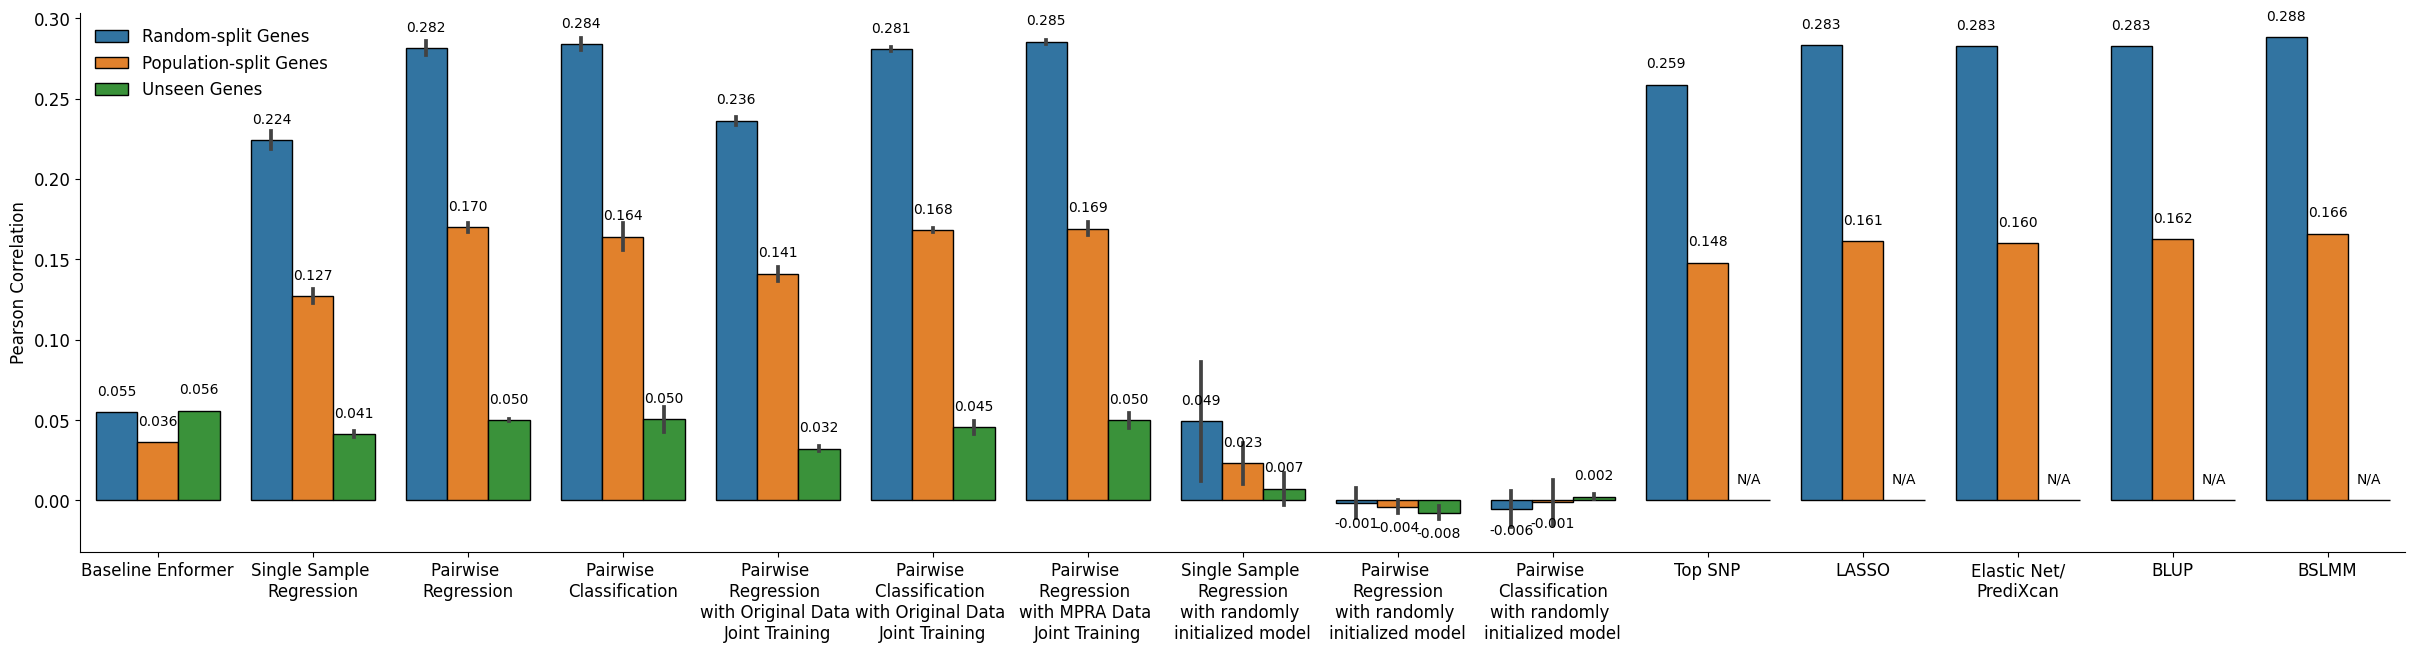

In [9]:
fontsize = 10
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize + 2)
matplotlib.rc("ytick", labelsize=fontsize + 2)
fig, ax = plt.subplots(figsize=(30, 7))

sns.barplot(
    data=plot_df,
    x="Model Type",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    ax=ax,
    edgecolor="black",
    order=[
        "Baseline Enformer",
        "Single Sample \nRegression",
        "Pairwise \nRegression",
        "Pairwise \nClassification",
        "Pairwise \nRegression \nwith Original Data \nJoint Training",
        "Pairwise \nClassification \nwith Original Data \nJoint Training",
        "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
        "Single Sample \nRegression\nwith randomly \ninitialized model",
        "Pairwise \nRegression\nwith randomly \ninitialized model",
        "Pairwise \nClassification\nwith randomly \ninitialized model",
        "Top SNP",
        "LASSO",
        "Elastic Net/\nPrediXcan",
        "BLUP",
        "BSLMM",
    ],
)
# sns.stripplot(data=plot_df, x="Model Type", y="Pearson Correlation", hue="Gene Classes", ax=ax, dodge=True, alpha=1, legend=False,
#            order=["Baseline Enformer",
#                   "Single Sample \nRegression",
#                   "Pairwise \nRegression",
#                   "Pairwise \nClassification",
#                   "Pairwise \nRegression \nwith Original Data \nJoint Training",
#                   "Pairwise \nClassification \nwith Original Data \nJoint Training",
#                   "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
#                   "Top SNP",
#                   "LASSO",
#                   "Elastic Net/\nPrediXcan",
#                   "BLUP",
#                   "BSLMM"])


def fmt_func(val):
    if val == 0:
        return "N/A"
    else:
        return f"{val:.3f}"


ax.bar_label(ax.containers[0], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[1], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[2], fontsize=fontsize, padding=10, fmt=fmt_func)
plt.xlabel("")
ax.yaxis.label.set_size(fontsize + 2)
plt.legend(frameon=False, prop={"size": fontsize + 2})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

os.makedirs("figures", exist_ok=True)
plt.savefig(
    "figures/fig_S3_comparison_of_all_methods.pdf", dpi=600, bbox_inches="tight"
)
plt.savefig(
    "figures/fig_S3_comparison_of_all_methods.svg", dpi=600, bbox_inches="tight"
)
# plt.tick_params(axis="x", labelrotation=45)

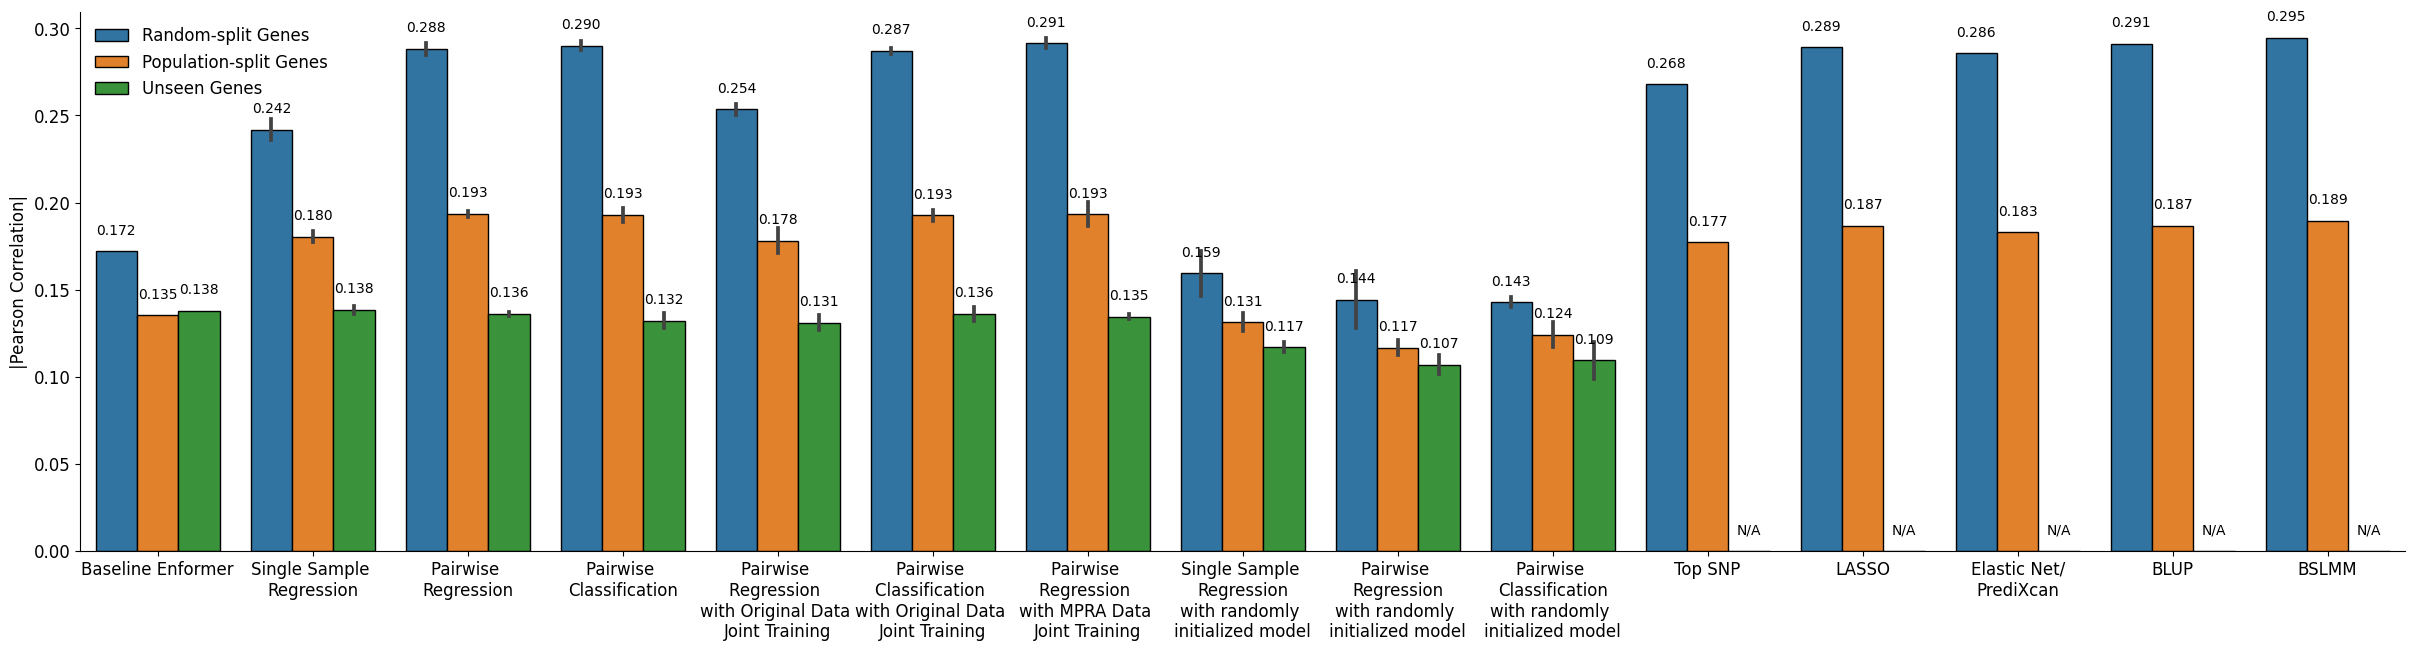

In [10]:
fontsize = 10
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize + 2)
matplotlib.rc("ytick", labelsize=fontsize + 2)
fig, ax = plt.subplots(figsize=(30, 7))

sns.barplot(
    data=plot_df,
    x="Model Type",
    y="|Pearson Correlation|",
    hue="Gene Classes",
    errorbar="sd",
    ax=ax,
    edgecolor="black",
    order=[
        "Baseline Enformer",
        "Single Sample \nRegression",
        "Pairwise \nRegression",
        "Pairwise \nClassification",
        "Pairwise \nRegression \nwith Original Data \nJoint Training",
        "Pairwise \nClassification \nwith Original Data \nJoint Training",
        "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
        "Single Sample \nRegression\nwith randomly \ninitialized model",
        "Pairwise \nRegression\nwith randomly \ninitialized model",
        "Pairwise \nClassification\nwith randomly \ninitialized model",
        "Top SNP",
        "LASSO",
        "Elastic Net/\nPrediXcan",
        "BLUP",
        "BSLMM",
    ],
)
# sns.stripplot(data=plot_df, x="Model Type", y="|Pearson Correlation|", hue="Gene Classes", ax=ax, dodge=True, alpha=1, legend=False,
#            order=["Baseline Enformer",
#                   "Single Sample \nRegression",
#                   "Pairwise \nRegression",
#                   "Pairwise \nClassification",
#                   "Pairwise \nRegression \nwith Original Data \nJoint Training",
#                   "Pairwise \nClassification \nwith Original Data \nJoint Training",
#                   "Pairwise \nRegression \nwith MPRA Data \nJoint Training",
#                   "Top SNP",
#                   "LASSO",
#                   "Elastic Net/\nPrediXcan",
#                   "BLUP",
#                   "BSLMM"])


def fmt_func(val):
    if val == 0:
        return "N/A"
    else:
        return f"{val:.3f}"


ax.bar_label(ax.containers[0], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[1], fontsize=fontsize, padding=10, fmt=fmt_func)
ax.bar_label(ax.containers[2], fontsize=fontsize, padding=10, fmt=fmt_func)
plt.xlabel("")
ax.yaxis.label.set_size(fontsize + 2)
plt.legend(frameon=False, prop={"size": fontsize + 2})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

os.makedirs("figures", exist_ok=True)
plt.savefig(
    "figures/fig_S4_comparison_of_all_methods_abs_perf.pdf",
    dpi=600,
    bbox_inches="tight",
)
plt.savefig(
    "figures/fig_S4_comparison_of_all_methods_abs_perf.svg",
    dpi=600,
    bbox_inches="tight",
)
# plt.tick_params(axis="x", labelrotation=45)

# Scatterplots comparing baselines to fine-tuned Enformer - fig S5

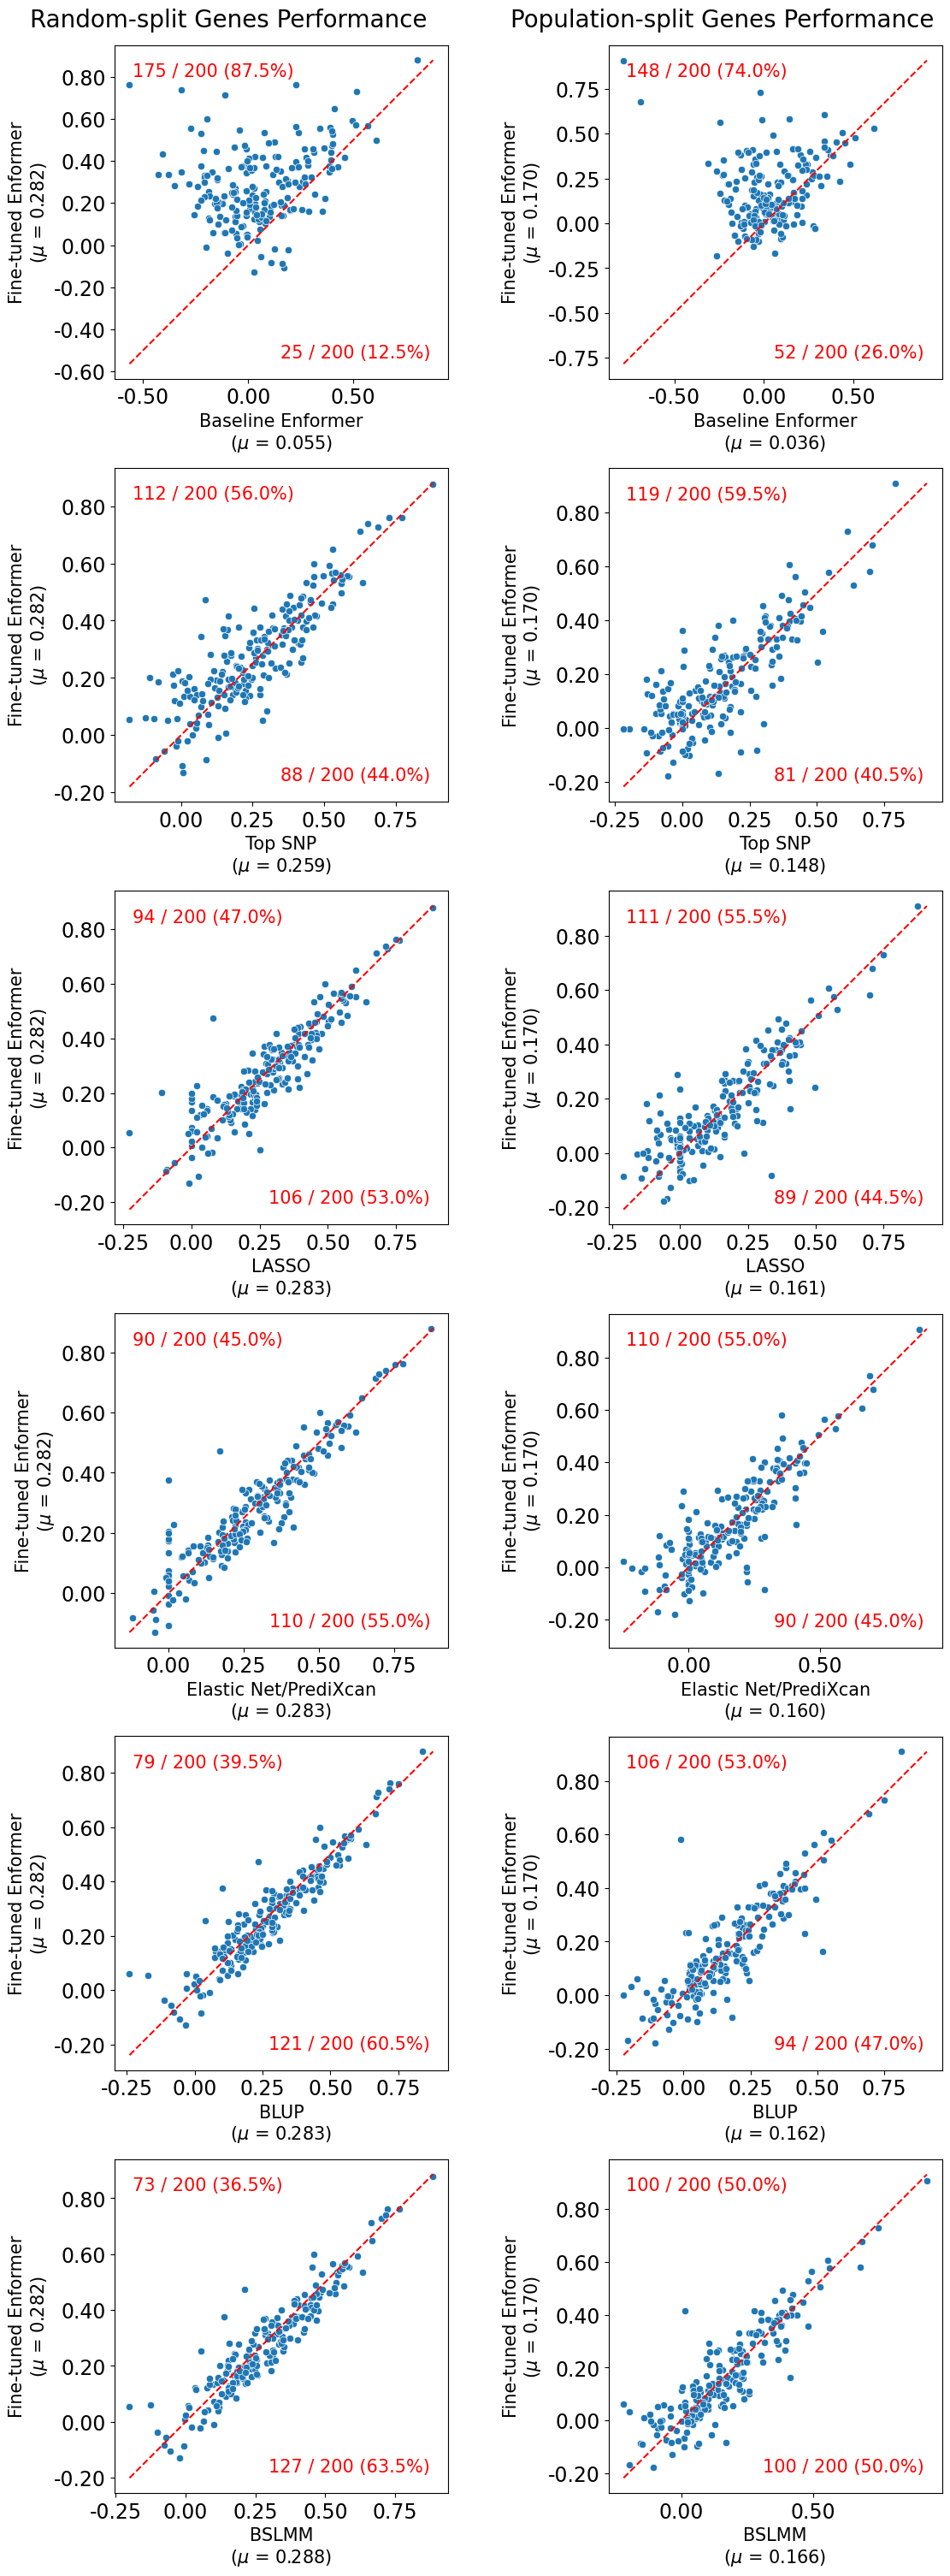

In [12]:
fontsize = 15
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize + 2)
matplotlib.rc("ytick", labelsize=fontsize + 2)

fig = plt.figure(figsize=(11, 30), constrained_layout=True)
subfigs = fig.subfigures(nrows=1, ncols=2, wspace=0.1, hspace=0.1)
for i, split in enumerate(["random_split", "yri_split"]):
    finetuned_enformer_perf = gene_perf[
        (
            gene_perf["model"]
            == "regression_data_seed_42_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3"
        )
        | (
            gene_perf["model"]
            == "regression_data_seed_97_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3"
        )
        | (
            gene_perf["model"]
            == "regression_data_seed_7_lr_0.0001_wd_0.001_rcprob_0.5_rsmax_3"
        )
    ]
    finetuned_enformer_perf = finetuned_enformer_perf[
        finetuned_enformer_perf["class"] == split
    ]
    finetuned_enformer_perf = finetuned_enformer_perf[["gene", "Pearson", "|Pearson|"]]
    finetuned_enformer_perf = finetuned_enformer_perf.groupby(["gene"]).mean()

    # set the title of the row to the split
    if split == "random_split":
        row_title = "Random-split Genes Performance"
    else:
        row_title = "Population-split Genes Performance"
    subfigs[i].suptitle(row_title, fontsize=fontsize + 5)

    ax = subfigs[i].subplots(6, 1)

    for j, baseline in enumerate(
        ["baseline", "Top SNP", "LASSO", "Elastic Net/\nPrediXcan", "BLUP", "BSLMM"]
    ):
        baseline_perf = gene_perf[gene_perf["model"] == baseline]
        baseline_perf = baseline_perf[baseline_perf["class"] == split]
        baseline_perf = baseline_perf.merge(
            finetuned_enformer_perf,
            on="gene",
            how="inner",
            suffixes=("_baseline", "_finetuned"),
        ).reset_index(drop=True)

        sns.scatterplot(
            data=baseline_perf, x="Pearson_baseline", y="Pearson_finetuned", ax=ax[j]
        )

        min_lim = min(
            baseline_perf["Pearson_baseline"].min(),
            baseline_perf["Pearson_finetuned"].min(),
        )
        max_lim = max(
            baseline_perf["Pearson_baseline"].max(),
            baseline_perf["Pearson_finetuned"].max(),
        )

        ax[j].plot(
            np.arange(min_lim, max_lim + 0.001, 0.001),
            np.arange(min_lim, max_lim + 0.001, 0.001),
            "r--",
            label="x=y",
        )

        if baseline == "baseline":
            baseline = "Baseline Enformer"
        ax[j].set_xlabel(
            baseline.replace("\n", "")
            + "\n"
            + r"($\mu$ = {:.3f})".format(baseline_perf["Pearson_baseline"].mean())
        )
        ax[j].set_ylabel(
            "Fine-tuned Enformer"
            + "\n"
            + r"($\mu$ = {:.3f})".format(baseline_perf["Pearson_finetuned"].mean())
        )

        # display number of points above the diagonal and below the diagonal along with the percentage
        above_diagonal = baseline_perf[
            baseline_perf["Pearson_finetuned"] > baseline_perf["Pearson_baseline"]
        ]
        below_diagonal = baseline_perf[
            baseline_perf["Pearson_finetuned"] < baseline_perf["Pearson_baseline"]
        ]
        # show above diagonal points near the top left corner
        text_box = AnchoredText(
            f"{len(above_diagonal)} / {len(baseline_perf)} ({len(above_diagonal) / len(baseline_perf) * 100:.1f}%)",
            frameon=False,
            loc="upper left",
            pad=0.5,
            prop={"color": "red"},
        )
        text_box.patch.set_alpha(0.5)
        ax[j].add_artist(text_box)
        # show below diagonal points near the bottom right corner
        text_box = AnchoredText(
            f"{len(below_diagonal)} / {len(baseline_perf)} ({len(below_diagonal) / len(baseline_perf) * 100:.1f}%)",
            frameon=False,
            loc="lower right",
            pad=0.5,
            prop={"color": "red"},
        )
        text_box.patch.set_alpha(0.5)
        ax[j].add_artist(text_box)

        # make precision of x and y ticks to 2 decimal places
        ax[j].xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
        ax[j].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.2f"))
        ax[j].set_aspect("equal")

plt.savefig(
    f"figures/fig_S5_scatterplot_finetuned_vs_baselines.pdf",
    dpi=600,
    bbox_inches="tight",
)
plt.savefig(
    f"figures/fig_S5_scatterplot_finetuned_vs_baselines.svg",
    dpi=600,
    bbox_inches="tight",
)

plt.show()

# Generate figure showing how performance scales with number of samples - fig 6

In [13]:
plot_df = {}
plot_df["Method"] = []
plot_df["Subsample Ratio"] = []
plot_df["% of Samples Used for Training"] = []
plot_df["Replicate"] = []
plot_df["Gene Classes"] = []
plot_df["Pearson Correlation"] = []
plot_df["|Pearson Correlation|"] = []

for i in range(1, summary_df.shape[0]):
    row = summary_df.iloc[i]

    if row["Subsample Ratio"] == -1 or "_af_" in row["Model"]:
        continue

    plot_df["Method"].append("Fine-tuned Enformer")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random-split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["random_split Genes Avg |PearsonR|"])

    plot_df["Method"].append("Fine-tuned Enformer")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population-split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["yri_split Genes Avg |PearsonR|"])

    plot_df["Method"].append("Fine-tuned Enformer")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Unseen Genes")
    plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["unseen Genes Avg |PearsonR|"])


for i in range(fusion_scaling_df.shape[0]):
    row = fusion_scaling_df.iloc[i]

    if row["Subsample Ratio"] == -1 or "_af_" in row["Model"]:
        continue

    plot_df["Method"].append("BLUP")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"]))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random-split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["random_split Genes Avg |PearsonR|"])

    plot_df["Method"].append("BLUP")
    plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"]))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population-split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
    plot_df["|Pearson Correlation|"].append(row["yri_split Genes Avg |PearsonR|"])

    # plot_df["Method"].append("BLUP")
    # plot_df["Subsample Ratio"].append(row["Subsample Ratio"])
    # plot_df["% of Samples Used for Training"].append(int(row["Subsample Ratio"]))
    # plot_df["Replicate"].append(row["Replicate"])
    # plot_df["Gene Classes"].append("Unseen Genes")
    # plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
    # plot_df["|Pearson Correlation|"].append(row["unseen Genes Avg |PearsonR|"])

plot_df = pd.DataFrame(plot_df)

In [14]:
plot_df

,Method,Subsample Ratio,% of Samples Used for Training,Replicate,Gene Classes,Pearson Correlation,|Pearson Correlation|
0,Fine-tuned Enformer,1.0,100,42,Random-split Genes,0.277739,0.286450
1,Fine-tuned Enformer,1.0,100,42,Population-split Genes,0.167516,0.191992
2,Fine-tuned Enformer,1.0,100,42,Unseen Genes,0.050255,0.134924
3,Fine-tuned Enformer,0.2,20,42,Random-split Genes,0.219492,0.240743
4,Fine-tuned Enformer,0.2,20,42,Population-split Genes,0.129576,0.176059
...,...,...,...,...,...,...,...
70,BLUP,100.0,100,2,Population-split Genes,0.162383,0.186806
71,BLUP,100.0,100,1,Random-split Genes,0.282717,0.291098
72,BLUP,100.0,100,1,Population-split Genes,0.162383,0.186806
73,BLUP,100.0,100,3,Random-split Genes,0.282717,0.291098


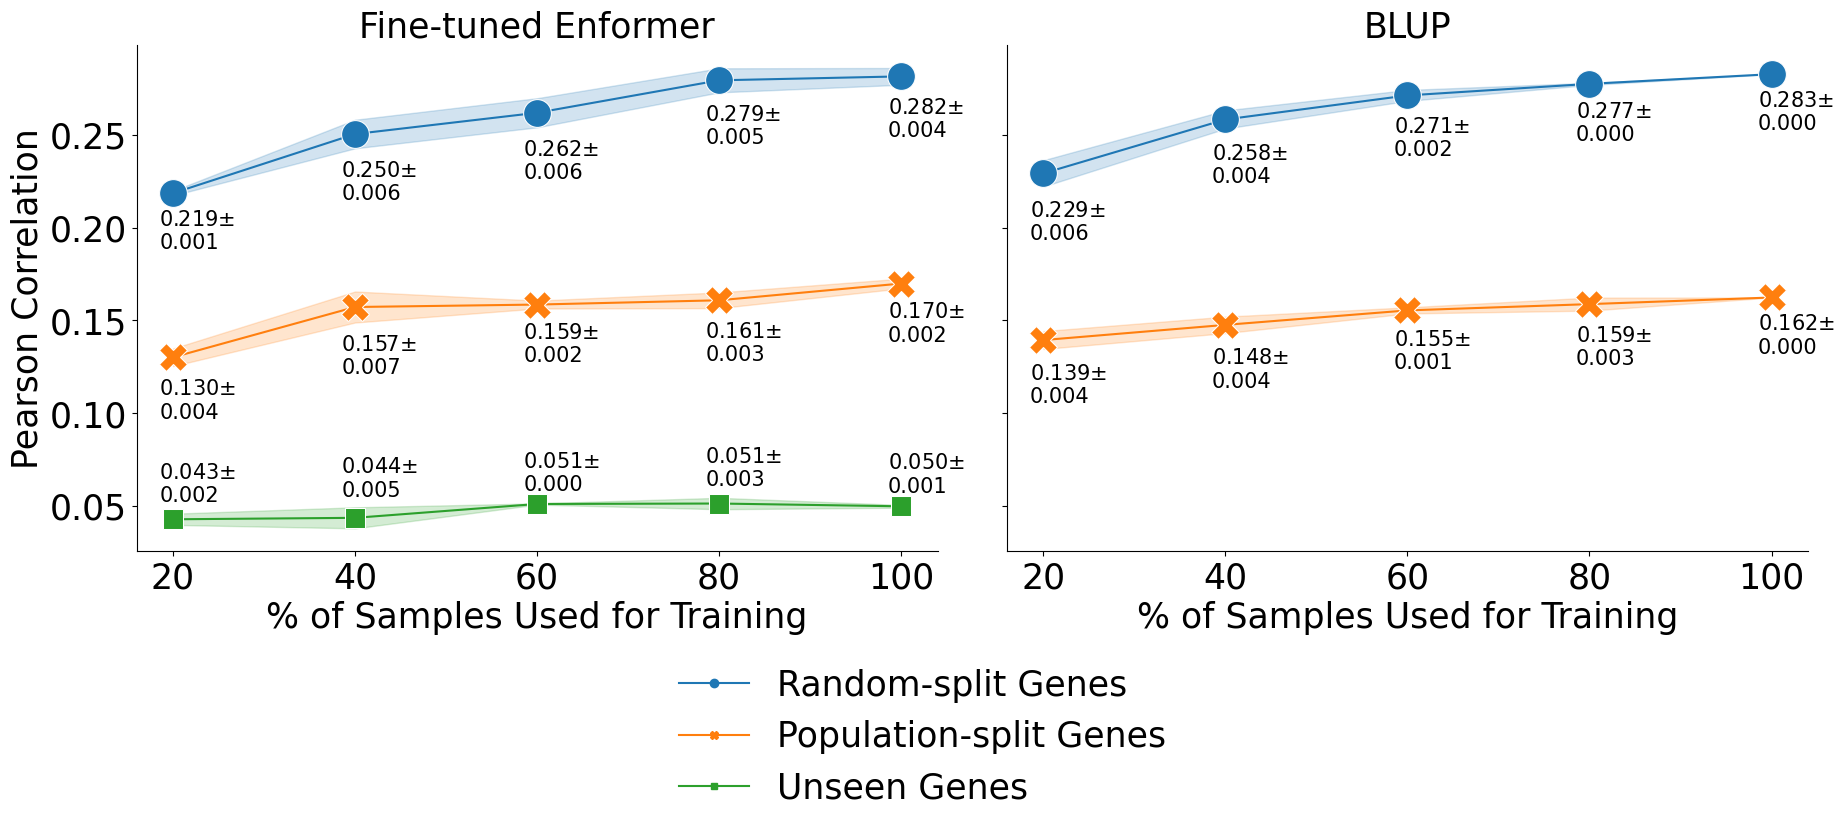

In [15]:
fontsize = 25
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize)
matplotlib.rc("ytick", labelsize=fontsize)
fig, ax = plt.subplots(1, 2, figsize=(19, 7), sharey=True, tight_layout=True)

sns.lineplot(
    data=plot_df[(plot_df["Method"] == "Fine-tuned Enformer")].reset_index(drop=True),
    x="% of Samples Used for Training",
    style="Gene Classes",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    markers=True,
    dashes=False,
    markersize=20,
    #              err_style="bars",
    hue_order=["Random-split Genes", "Population-split Genes", "Unseen Genes"],
    ax=ax[0],
)

# label points on the plot
for x in set(plot_df["% of Samples Used for Training"]):
    for hue in set(plot_df["Gene Classes"]):
        corrs = plot_df[
            (plot_df["Method"] == "Fine-tuned Enformer")
            & (plot_df["% of Samples Used for Training"] == x)
            & (plot_df["Gene Classes"] == hue)
        ]["Pearson Correlation"]
        disp = f"{np.mean(corrs):.3f}" + r"$\pm$" + f"\n{np.std(corrs):.3f}"

        y = np.mean(corrs) - np.std(corrs) - 0.029
        if hue == "Unseen Genes":
            y = np.mean(corrs) + np.std(corrs) + 0.007
        ax[0].text(
            x=x - 1.5,  # x-coordinate position of data label
            y=y,  # y-coordinate position of data label, adjusted to be 150 below the data point
            s=disp,  # data label, formatted to ignore decimals
            fontsize=fontsize - 10,
            color="black",
        )  # set colour of line
ax[0].set_title("Fine-tuned Enformer", fontsize=fontsize)
ax[0].yaxis.label.set_size(fontsize)
ax[0].xaxis.label.set_size(fontsize)
ax[0].spines["top"].set_visible(False)
ax[0].spines["right"].set_visible(False)

sns.lineplot(
    data=plot_df[plot_df["Method"] == "BLUP"].reset_index(drop=True),
    x="% of Samples Used for Training",
    style="Gene Classes",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    markers=True,
    dashes=False,
    markersize=20,
    #              err_style="bars",
    hue_order=["Random-split Genes", "Population-split Genes"],
    ax=ax[1],
)

# label points on the plot
for x in set(plot_df["% of Samples Used for Training"]):
    for hue in set(plot_df["Gene Classes"]):
        if hue == "Unseen Genes":
            continue
        corrs = plot_df[
            (plot_df["Method"] == "BLUP")
            & (plot_df["% of Samples Used for Training"] == x)
            & (plot_df["Gene Classes"] == hue)
        ]["Pearson Correlation"]
        disp = f"{np.mean(corrs):.3f}" + r"$\pm$" + f"\n{np.std(corrs):.3f}"

        ax[1].text(
            x=x - 1.5,  # x-coordinate position of data label
            y=np.mean(corrs)
            - np.std(corrs)
            - 0.03,  # y-coordinate position of data label, adjusted to be 150 below the data point
            s=disp,  # data label, formatted to ignore decimals
            fontsize=fontsize - 10,
            color="black",
        )  # set colour of line
ax[1].set_title("BLUP", fontsize=fontsize)
ax[1].yaxis.label.set_size(fontsize)
ax[1].xaxis.label.set_size(fontsize)
ax[1].spines["top"].set_visible(False)
ax[1].spines["right"].set_visible(False)

# create common legend and make other legend invisible
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 0.05),
    ncol=1,
    fontsize=fontsize,
    frameon=False,
)
ax[0].get_legend().remove()
ax[1].get_legend().remove()

plt.savefig("figures/fig_6_perf_vs_num_samples.pdf", dpi=600, bbox_inches="tight")
plt.savefig("figures/fig_6_perf_vs_num_samples.svg", dpi=600, bbox_inches="tight")
# plt.tick_params(axis="x", labelrotation=45)

# Generate figure showing how performance scales with min AF of variants - fig 5

In [16]:
plot_df = {}
plot_df["Min AF"] = []
plot_df["% Minimum AF in Training Set"] = []
plot_df["Replicate"] = []
plot_df["Gene Classes"] = []
plot_df["Pearson Correlation"] = []
# plot_df["|Pearson Correlation|"] = []

for i in range(1, summary_df.shape[0]):
    row = summary_df.iloc[i]

    if row["Min AF"] == -1:
        continue

    plot_df["Min AF"].append(row["Min AF"])
    plot_df["% Minimum AF in Training Set"].append(int(row["Min AF"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Random-split Genes")
    plot_df["Pearson Correlation"].append(row["random_split Genes Avg PearsonR"])
    #     plot_df["|Pearson Correlation|"].append(row["random_split Genes Avg |PearsonR|"])

    plot_df["Min AF"].append(row["Min AF"])
    plot_df["% Minimum AF in Training Set"].append(int(row["Min AF"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Population-split Genes")
    plot_df["Pearson Correlation"].append(row["yri_split Genes Avg PearsonR"])
    #     plot_df["|Pearson Correlation|"].append(row["yri_split Genes Avg |PearsonR|"])

    plot_df["Min AF"].append(row["Min AF"])
    plot_df["% Minimum AF in Training Set"].append(int(row["Min AF"] * 100))
    plot_df["Replicate"].append(row["Replicate"])
    plot_df["Gene Classes"].append("Unseen Genes")
    plot_df["Pearson Correlation"].append(row["unseen Genes Avg PearsonR"])
#     plot_df["|Pearson Correlation|"].append(row["unseen Genes Avg |PearsonR|"])

plot_df = pd.DataFrame(plot_df)

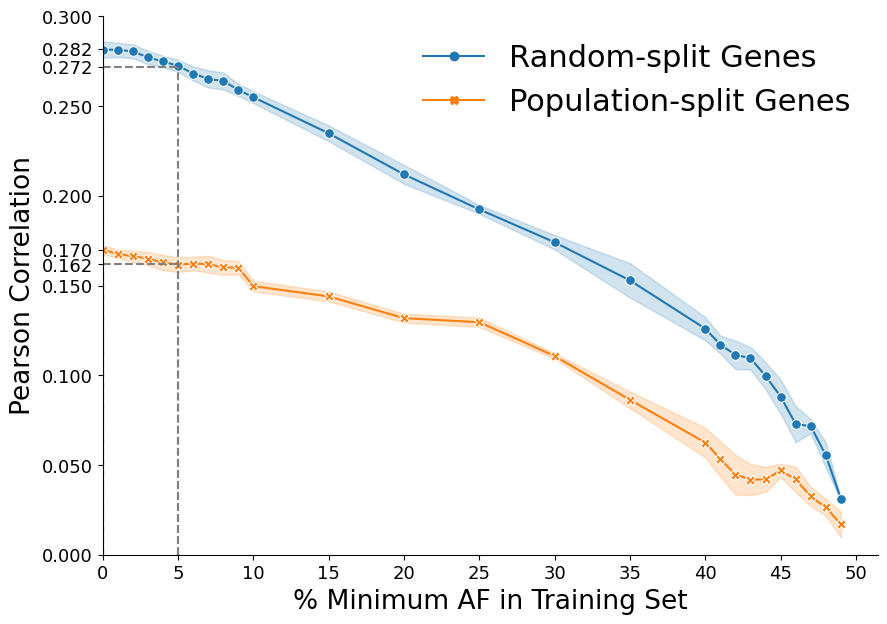

In [17]:
fontsize = 19
plt.rcParams.update({"font.size": fontsize})
matplotlib.rc("xtick", labelsize=fontsize - 6)
matplotlib.rc("ytick", labelsize=fontsize - 6)
fig, ax = plt.subplots(figsize=(10, 7))

sns.lineplot(
    data=plot_df[plot_df["Gene Classes"] != "Unseen Genes"],
    x="% Minimum AF in Training Set",
    style="Gene Classes",
    y="Pearson Correlation",
    hue="Gene Classes",
    errorbar="sd",
    ax=ax,
    markers=True,
    dashes=False,
    markersize=7,
    hue_order=["Random-split Genes", "Population-split Genes"],
)

af0_pearson_random = (
    plot_df[
        (plot_df["% Minimum AF in Training Set"] == 0)
        & (plot_df["Gene Classes"] == "Random-split Genes")
    ]["Pearson Correlation"]
    .mean()
    .round(3)
)
af0_pearson_population = (
    plot_df[
        (plot_df["% Minimum AF in Training Set"] == 0)
        & (plot_df["Gene Classes"] == "Population-split Genes")
    ]["Pearson Correlation"]
    .mean()
    .round(3)
)
af5_pearson_random = (
    plot_df[
        (plot_df["% Minimum AF in Training Set"] == 5)
        & (plot_df["Gene Classes"] == "Random-split Genes")
    ]["Pearson Correlation"]
    .mean()
    .round(3)
)
af5_pearson_population = (
    plot_df[
        (plot_df["% Minimum AF in Training Set"] == 5)
        & (plot_df["Gene Classes"] == "Population-split Genes")
    ]["Pearson Correlation"]
    .mean()
    .round(3)
)

plt.vlines(
    [0, 0],
    0,
    [af0_pearson_random, af0_pearson_population],
    colors="gray",
    linestyle="dashed",
)
plt.hlines(
    [af0_pearson_random, af0_pearson_population],
    0,
    [0, 0],
    colors="gray",
    linestyle="dashed",
)

plt.vlines(
    [5, 5],
    0,
    [af5_pearson_random, af5_pearson_population],
    colors="gray",
    linestyle="dashed",
)
plt.hlines(
    [af5_pearson_random, af5_pearson_population],
    0,
    [5, 5],
    colors="gray",
    linestyle="dashed",
)

xticks = np.arange(0, max(all_afs) * 100 + 5, 5)
yticks = np.arange(0, max(plot_df["Pearson Correlation"]) + 0.025, 0.05).round(
    3
).tolist() + [
    af0_pearson_random,
    af0_pearson_population,
    af5_pearson_random,
    af5_pearson_population,
]
plt.xticks(xticks)
plt.yticks(yticks)

plt.xlim(0, None)
plt.ylim(0, None)
plt.legend(frameon=False, prop={"size": fontsize + 3})
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)

plt.savefig("figures/fig_5_perf_vs_min_AF.pdf", dpi=600, bbox_inches="tight")
plt.savefig("figures/fig_5_perf_vs_min_AF.svg", dpi=600, bbox_inches="tight")
# plt.tick_params(axis="x", labelrotation=45)